## **Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification**

### Name: Tejaswini Marolia
### Student Id: 8944151
### Section: 2

### **Objective:**

##### In this lab, the objective is to develop and evaluate models that classify images of dogs and cats effectively, both by designing a neural network and using transfer learning with a pre-trained model, VGG16. This exercise will help in understanding how to build and fine-tune deep learning models on a specific task with proper evaluation and insight into the performance of the model.

### **Code Reference:**

- #### [05A_asirra_the_dogs_vs_cats_dataset.ipynb](https://github.com/CSCN8010/CSCN8010/blob/main/dl_class_notebooks/05A_asirra_the_dogs_vs_cats_dataset.ipynb)
- #### [05C_dogs_vs_cats_cnn_and_data_augmentation.ipynb](https://github.com/CSCN8010/CSCN8010/blob/main/dl_class_notebooks/05C_dogs_vs_cats_cnn_and_data_augmentation.ipynb)
- #### [05D_fine_tuning_vgg16.ipynb](https://github.com/CSCN8010/CSCN8010/blob/main/dl_class_notebooks/05D_fine_tuning_vgg16.ipynb)

### **Importing Libraries**

In [9]:
import os, shutil, pathlib

from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, ConfusionMatrixDisplay

### **Obtaining the Data**
#### The dataset is taken from: [Kaggle - Dogs versus Cats](https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats)

### **1. Loading Data**

In [10]:
data_folder = pathlib.Path("C:\\Users\\Tejaswini Marolia\\Downloads\\kaggle_dogs_vs_cats_small")

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
# Count images in each class
train_dir = data_folder / "train"
class_counts = {folder.name: len(list(folder.glob("*.jpg"))) for folder in train_dir.iterdir()}
print("Class counts:", class_counts)


Class counts: {'cat': 1000, 'dog': 1000}


### **2. Visualizing data**

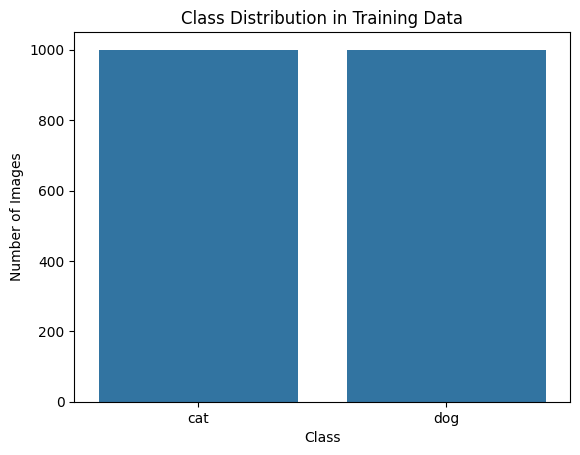

In [12]:
# Visualize class distribution
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

This image shows the class distribution of the training dataset in a bar chart manner.

1. Classes: Classes include "cat" and "dog.".

2. Balanced: The number of images in both classes is equal, which is reflected in the bars being of equal height.

3. Balanced Dataset: The dataset will be considered balanced, as the number of samples for each class is equal, which is important in training machine learning models to avoid bias toward one class.

4. Number of Images: According to the graph, there are about 1000 images per class in the training dataset.

### **3.Analyzing and Visualizing Image Dimension Distributions**

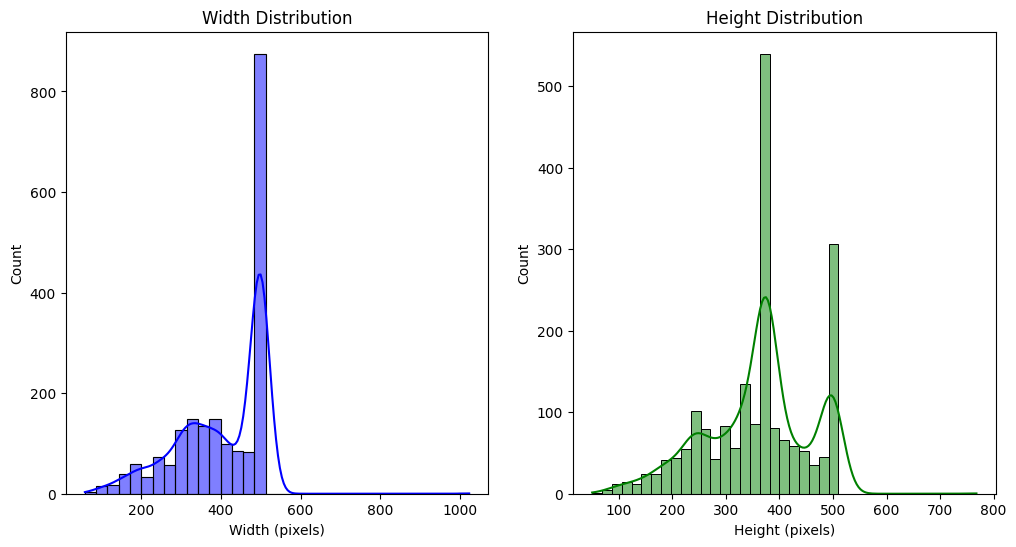

In [13]:
# Analyze image dimensions
image_shapes = []
for img_path in train_dir.glob("*/*.jpg"):
    with Image.open(img_path) as img:
        image_shapes.append(img.size)

# Convert to numpy array
image_shapes = np.array(image_shapes)
widths, heights = image_shapes[:, 0], image_shapes[:, 1]

# Plot distributions of width and height
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True, color='blue')
plt.title("Width Distribution")
plt.xlabel("Width (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True, color='green')
plt.title("Height Distribution")
plt.xlabel("Height (pixels)")
plt.show()


#### Width Distribution:
- The **Width Distribution** plot (left) indicates that most of the images are clustered around **500 pixels**, with a strong peak at this value.
- A number of images have smaller widths below 500 pixels, suggesting variation in the size of images within the dataset.
- There is a smooth curve, or kernel density estimation, overlaying the histogram to show the overall trend, confirming strong central tendency around the value 500 pixels.

#### Distribution of Heights:
- The **Height Distribution** plot on the right shows two major peaks: one at approximately **400 pixels** and another around **500 pixels**. This might indicate that the data may be images from two sets of height ranges, such as images with different aspect ratios or from two sources.
- As with widths, there are some smaller height values, but it looks like most of the data falls in these two peaks.

#### Overall Observations:
- The dataset contains some uniformity in image sizes but also displays variability, especially in the height dimension. It is bimodal.
- This may require preprocessing of the images, such as resizing them to one common dimension, depending on your task, for consistency in input size to models.

### **4. Displaying Sample images of Dogs and Cats**

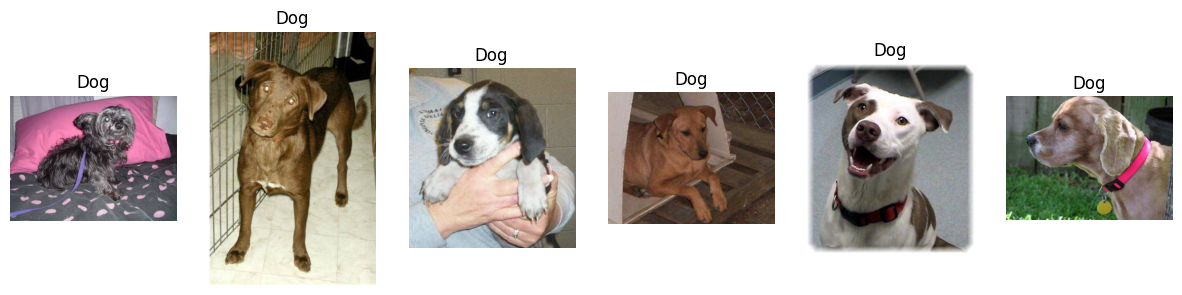

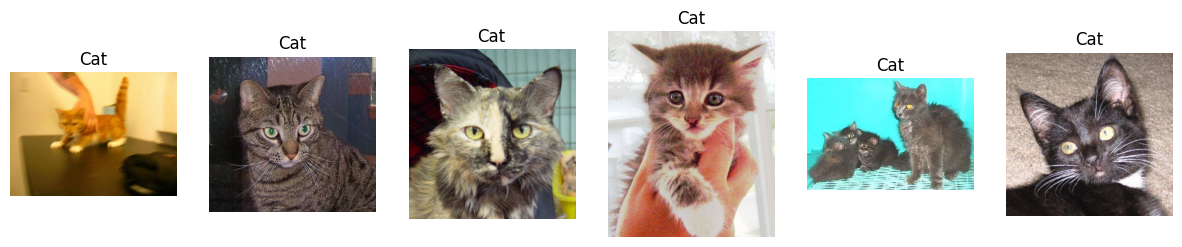

In [14]:
def show_sample_images(data_path, class_name, num_images=5):
    # Convert data_path to a Path object if it's not already
    data_path = Path(data_path)
    class_path = data_path / class_name
    sample_images = list(class_path.glob("*.jpg"))[:num_images]
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name.capitalize())
    plt.show()

# Display sample images
show_sample_images("C:\\Users\\Tejaswini Marolia\\Downloads\\kaggle_dogs_vs_cats_small\\train","dog",6)
show_sample_images("C:\\Users\\Tejaswini Marolia\\Downloads\\kaggle_dogs_vs_cats_small\\train","cat", 6)


Above are sample images from the "Dogs vs Cats" dataset, from the two classes: "dog" and "cat." Each set contains 5 randomly selected images from the specified directory. These samples show the visual diversity of the dataset, ranging from different breeds to poses and lighting conditions. In the "dog" class, each image shows a different dog in a unique setting, while the "cat" class features a variety of cats. This exploration emphasizes the dataset's variability and potential challenges, such as differing angles, lighting, and noise-including blurry or partially obscured images-factors crucial to consider when training a classification model.

### **Convolutional Neural Network (CNN)**

In [15]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_cnn = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

CNN Model Summary

The code given below is for a CNN binary image classifier using the Keras API from TensorFlow. Below is an overview:

1. **Input Layer**:
   - Image size: 180x180, with 3 color channels (RGB).

2. **Data Normalization**:
   - All pixel values are scaled between the range [0, 1] through `Rescaling(1./255)`.

3. **Feature Extraction:
- Five `Conv2D` layers are utilized to extract features from the images with increasing filters (32, 64, 128, and 256), each using ReLU activation.
   - `MaxPooling2D` layers are followed by each convolutional layer to downsample feature maps and reduce computational complexity.

4. **Flattening**:
   - A `Flatten` layer converts the multi-dimensional feature maps into a 1D vector.

5. **Output Layer**:
- A `Dense` layer with a sigmoid activation outputs a probability for binary classification.

6. **Model Creation**:
   - Combine all layers into one complete model that is ready for training and prediction.

The model is designed to solve the classic problem of binary classification (dog vs. cat) using convolutional operations to learn features and classify the images.


#### **Compling the Model**

In [17]:
model_cnn.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

The CNN model is compiled for training that has the following key ingredients, in particular:

1. **Loss Function**: Here the loss function of choice would be the **binary cross-entropy**-the so-called binary classification where an output or response needs to be of only one class among a number of two classes, for instance: a dog versus a cat.

2. **Optimizer**: **RMSprop** is selected as the optimizer, an adaptive learning rate method that helps adjust the model's weights during training. It scales the learning rate based on the moving average of recent gradients, making it effective for training deep learning models.

3. **Metrics**: The model assesses the performance by **accuracy**, which is a measure of the percentage of correct predictions. This metric is usually used in classification tasks to monitor the progress of the model during training.

In essence, this code prepares the CNN for binary classification by specifying the loss function, optimization strategy, and evaluation metric, readying the model for training on data.

### **Training CNN Model with Checkpoint Callbacks for Best Validation Loss:**

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model_cnn.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.5026 - loss: 1.1999 - val_accuracy: 0.5030 - val_loss: 0.6920
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5122 - loss: 0.6971 - val_accuracy: 0.5000 - val_loss: 0.7002
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5150 - loss: 0.6987 - val_accuracy: 0.5090 - val_loss: 0.6878
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5631 - loss: 0.6878 - val_accuracy: 0.6510 - val_loss: 0.6565
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6136 - loss: 0.6596 - val_accuracy: 0.6180 - val_loss: 0.6485
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6411 - loss: 0.6304 - val_accuracy: 0.5990 - val_loss: 0.6706
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.6808 - loss: 0.6025 - val_accuracy: 0.7000 - val_loss: 0.5759
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7176 - loss: 0.5586 - val_accuracy: 0.7020 - val_loss:

The above code serves as a means through which training of a Convolutional Neural Network, or CNN, model is implemented using a ModelCheckpoint callback, saving the best model based on validation loss during training.

1. **`callbacks`**:
- The **ModelCheckpoint** callback is defined in a list. It monitors the **validation loss** (`val_loss`) during training and saves the model only when there is an improvement in the validation loss. The model is saved to the specified path `"./models/convnet_from_scratch.keras"`.
   - **`save_best_only=True`**: Ensures that the model is saved only when the validation loss improves, preventing overwriting with less optimal models.

2. **`model_cnn.fit()`**:
- **`train_dataset`**: This is the dataset used for training the model.
   - **`epochs=30`**: The model will be trained for 30 epochs.
   - **`validation_data=validation_dataset`**: This is the dataset that will be used to evaluate the model's performance during training; this provides a means to track the model's generalization ability.
- **`callbacks=callbacks`**: This defines the callback(s) to be utilized during training; in this instance, the **ModelCheckpoint** for monitoring validation loss.

### Summary:
 This code trains a CNN model using the provided training and validation datasets for 30 epochs. It saves the model whenever there is an improvement in the validation loss. This helps in retaining the best-performing model throughout the training process.


### **CNN Model Evaluation**

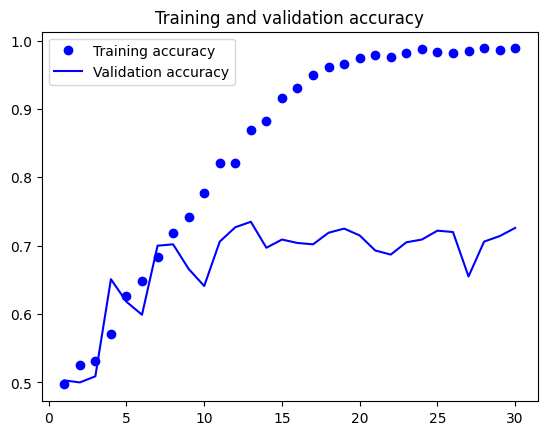

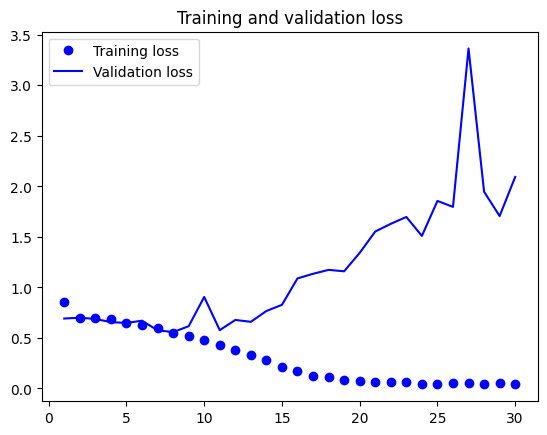

In [19]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### **Accuracy**

In [20]:
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 363ms/step - accuracy: 0.7056 - loss: 0.5752
Test accuracy: 0.711


#### **Confusion Matrix**

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 350ms/step


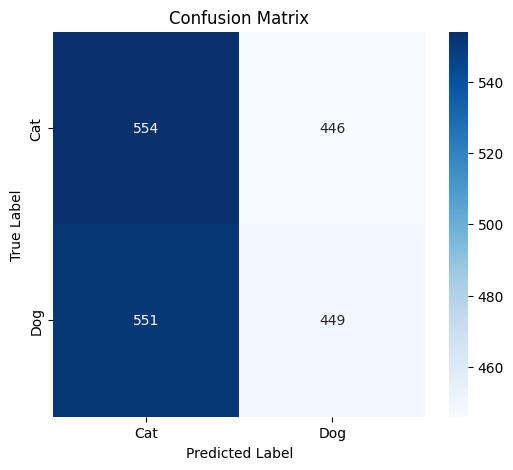

In [21]:
# Get predictions from the model
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # True labels
y_pred_probs = test_model.predict(test_dataset)               # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)                     # Convert probabilities to binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



#### **Classification Report**

In [22]:
# Classification Report: Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      0.55      0.53      1000
         Dog       0.50      0.45      0.47      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



#### **Precision-Recall Curve**

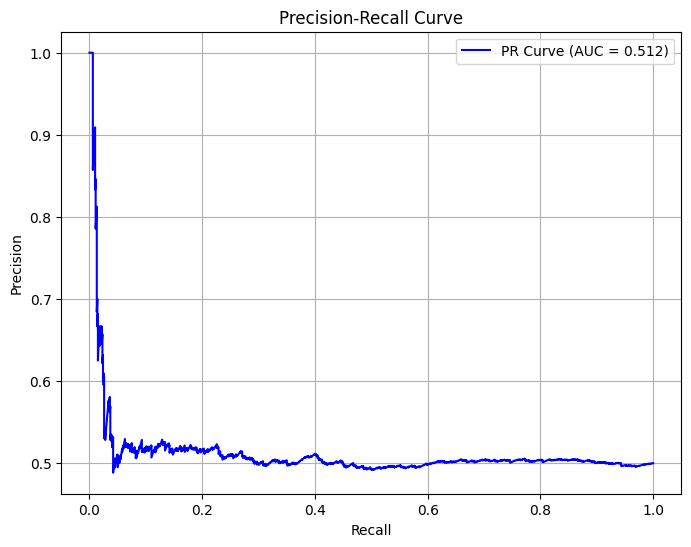

In [23]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

* The PR curve is plotted with the precision on the y-axis and recall on the x-axis. 
* A relatively low overall AUC of 0.485 implies the model does a poor job balancing the two sides.
* The shape of this curve indicates that precision drops initially when recall increases rapidly and then gradually flattens out, with limited improvement in precision for increased recall.
* Overall the PR curve seems to indicate that the model will probably fail to identify actual positives while keeping false positives as low as possible. Further analysis and model optimization might be required to improve performance.

#### **Exploring Incorrect Prediction**

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step


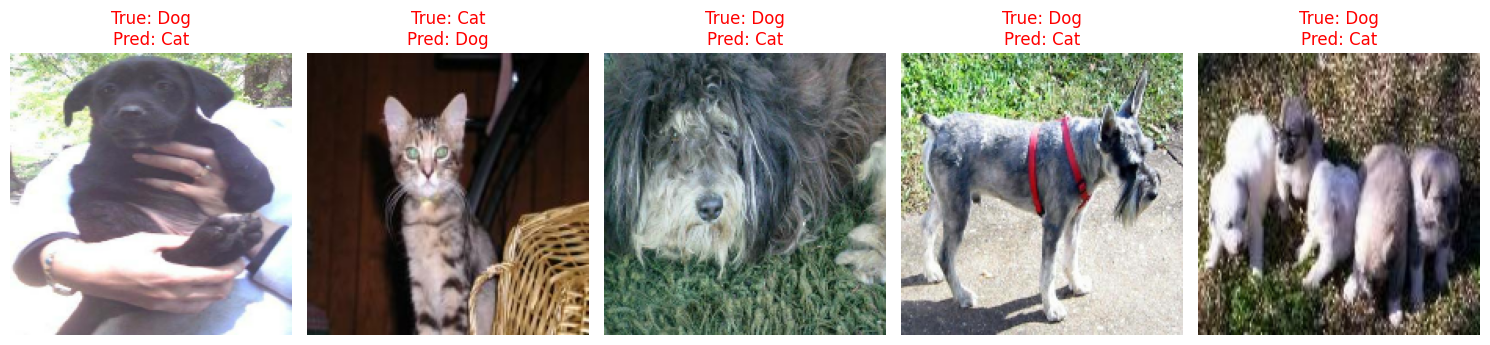

In [24]:
# Get true labels and predicted probabilities

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = test_model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)

# Identify misclassified examples
misclassified_indices = np.where(y_true != y_pred.ravel())[0]

# Load test images
test_images = np.concatenate([x.numpy() for x, y in test_dataset], axis=0)

# Display some misclassified examples
num_examples = min(5, len(misclassified_indices))  # Show up to 5 examples
plt.figure(figsize=(15, 5))

for i, idx in enumerate(misclassified_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(test_images[idx].astype("uint8"))  # Show the misclassified image
    true_label = "Dog" if y_true[idx] == 1 else "Cat"
    predicted_label = "Dog" if y_pred[idx] == 1 else "Cat"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()


#### **Data Augmentation in CNN**

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

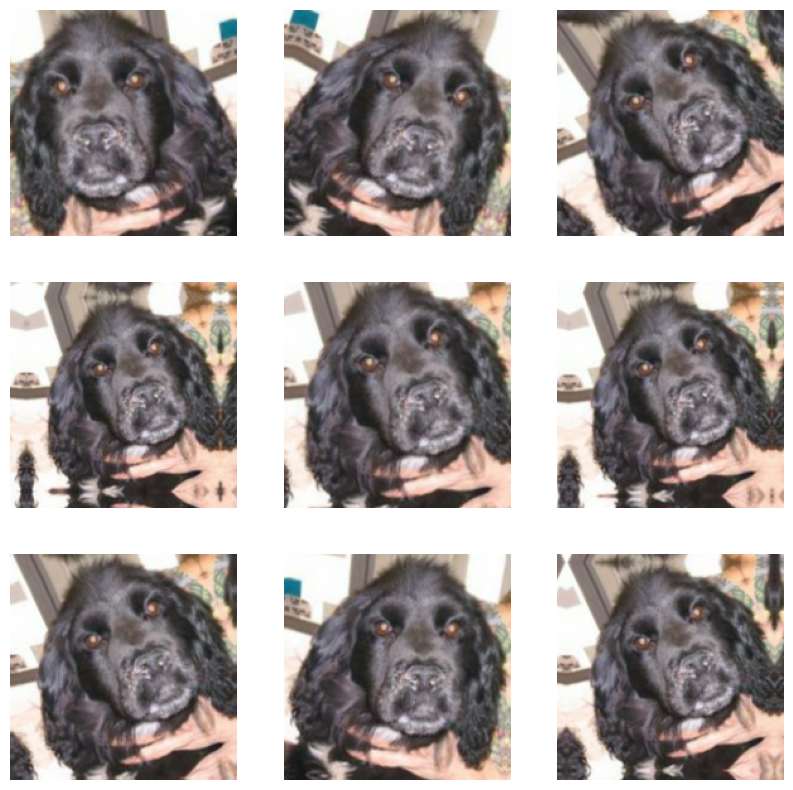

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

The above code performs data augmentation on a batch of images using the `Sequential` model from Keras. The augmentation includes three different transformations: random horizontal flipping, random rotation up to 0.1 radians, and random zoom up to 20%. Then, it displays the augmented images in a 3x3 grid. In each of the 9 subplots, one augmented image is shown, applying the mentioned transformations to the original batch. The sample images are provided from the `train_dataset`, and the resultant plot helps visualize how the data augmentation will introduce variety in the input images, hence making the model more robust because it is exposed to different variations during training.

#### **Developing and Putting Together a CNN Model for Data-Aided Binary Classification**

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [28]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.5081 - loss: 0.7962 - val_accuracy: 0.5050 - val_loss: 0.6926
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5197 - loss: 0.6939 - val_accuracy: 0.5090 - val_loss: 0.6905
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5436 - loss: 0.6903 - val_accuracy: 0.5230 - val_loss: 0.6961
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5852 - loss: 0.6752 - val_accuracy: 0.5570 - val_loss: 0.7561
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6128 - loss: 0.6443 - val_accuracy: 0.5830 - val_loss: 0.8384
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6266 - loss: 0.6671 - val_accuracy: 0.6270 - val_loss: 0.6768
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6455 - loss: 0.6269 - val_accuracy: 0.6350 - val_loss: 0.6495
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6717 - loss: 0.6047 - val_accuracy: 0.6100 - val_l

#### **Accuracy**

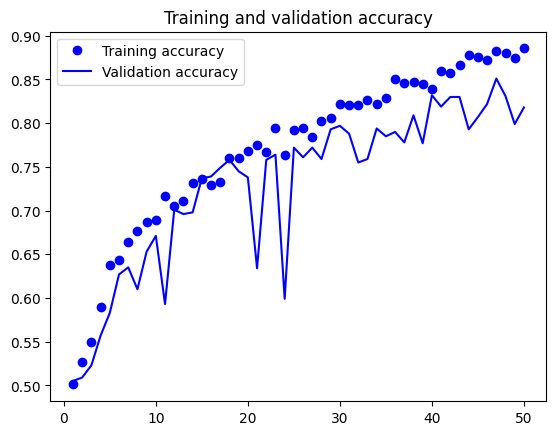

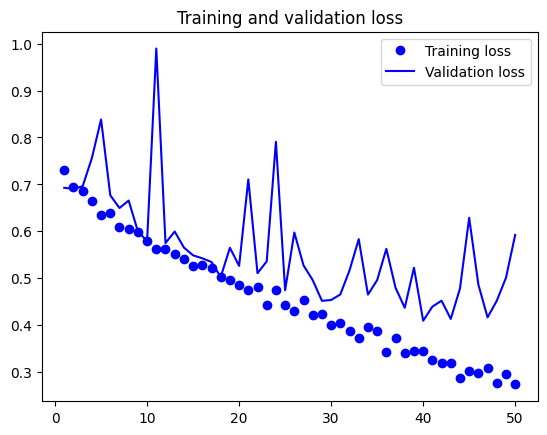

In [30]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### **Confusion Matrix**

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step


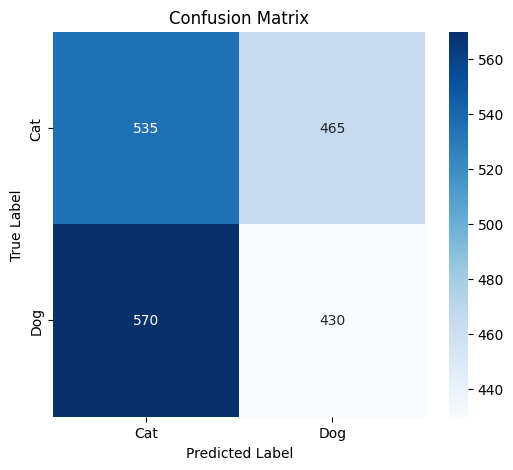

In [31]:
# Get predictions from the model
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # True labels
y_pred_probs = test_model.predict(test_dataset)               # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)                     # Convert probabilities to binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### **Classification Report**

In [32]:
# Classification Report: Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.48      0.54      0.51      1000
         Dog       0.48      0.43      0.45      1000

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000



#### **Precision-Recall Curve**

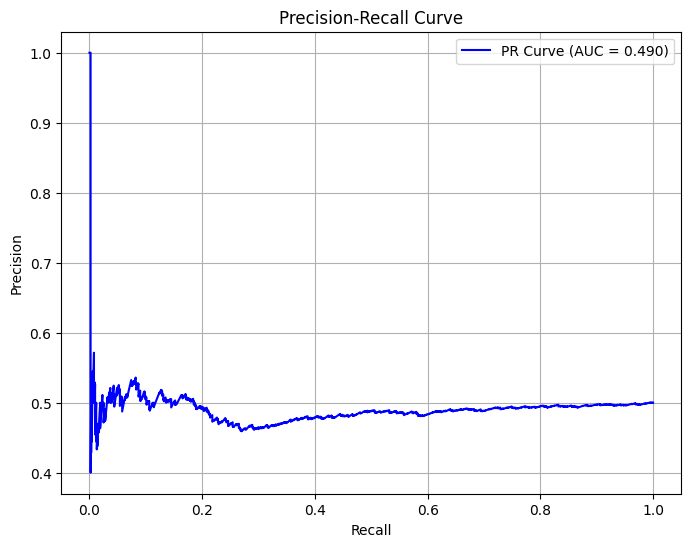

In [33]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

#### **Exploring Incorrect Prediction**

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step


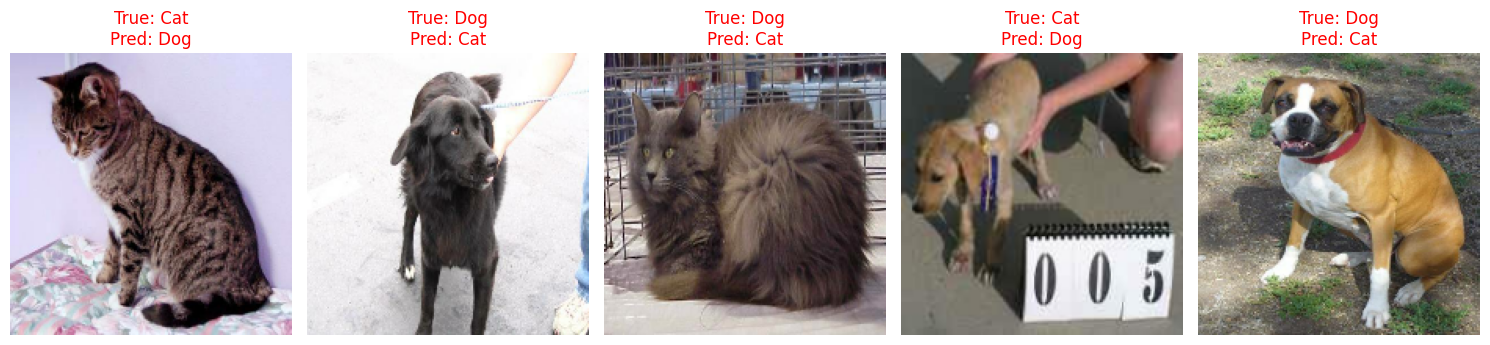

In [34]:
# Get true labels and predicted probabilities
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = test_model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)

# Identify misclassified examples
misclassified_indices = np.where(y_true != y_pred.ravel())[0]

# Load test images
test_images = np.concatenate([x.numpy() for x, y in test_dataset], axis=0)

# Display some misclassified examples
num_examples = min(5, len(misclassified_indices))  # Show up to 5 examples
plt.figure(figsize=(15, 5))

for i, idx in enumerate(misclassified_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(test_images[idx].astype("uint8"))  # Show the misclassified image
    true_label = "Dog" if y_true[idx] == 1 else "Cat"
    predicted_label = "Dog" if y_pred[idx] == 1 else "Cat"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()


### **VGG16**

### **Defining a model for VGG16**

In [35]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [36]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 

In [37]:
train_features.shape

(2000, 5, 5, 512)

In [38]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_vgg16 = keras.Model(inputs, outputs)

In [39]:
model_vgg16.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model_vgg16.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model_vgg16.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.8713 - loss: 42.7003 - val_accuracy: 0.9390 - val_loss: 10.0618
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9755 - loss: 3.6969 - val_accuracy: 0.9720 - val_loss: 3.4074
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9853 - loss: 1.7286 - val_accuracy: 0.9580 - val_loss: 9.4572
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9908 - loss: 0.9290 - val_accuracy: 0.9740 - val_loss: 4.3173
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9936 - loss: 0.8277 - val_accuracy: 0.9770 - val_loss: 3.6608
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9962 - loss: 0.3710 - val_accuracy: 0.9700 - val_loss: 8.0627
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9923 - loss: 1.0299 - val_accuracy: 0.9670 - val_loss: 8.2059
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9978 - loss: 0.1127 - val_accuracy: 0.9750 -

### **Evaluating VGG16 model** 

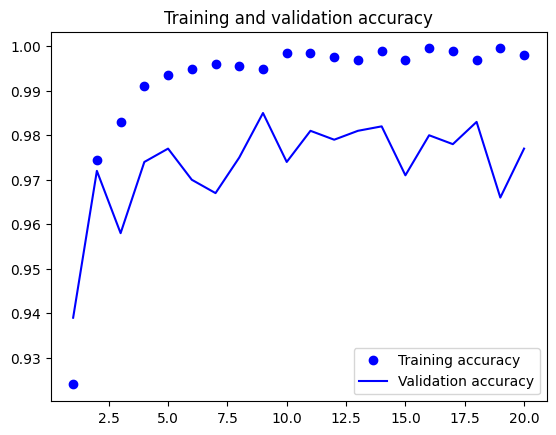

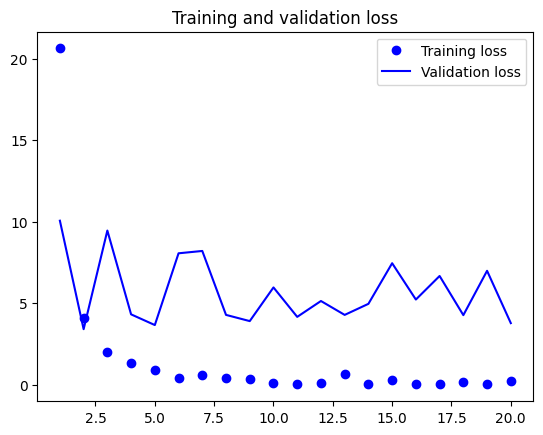

In [43]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### **Accuracy**

In [50]:
test_model = keras.models.load_model(
    "./models/feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9580 - loss: 5.3827
Test accuracy: 0.964


#### **Confusion Metric**

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


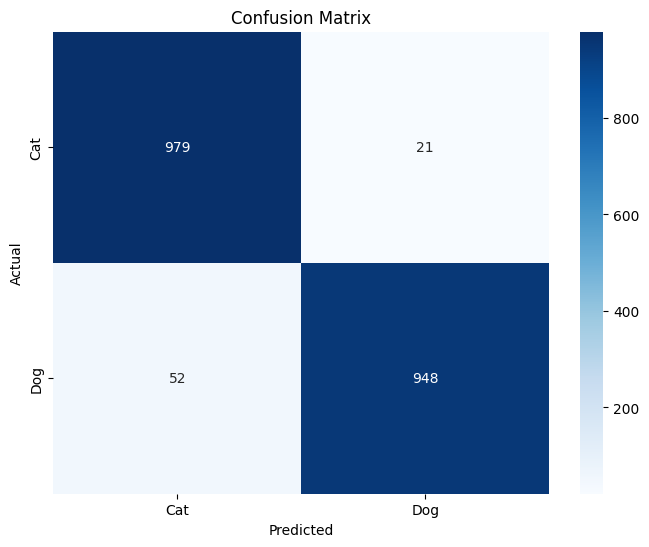

In [51]:
# Evaluate model predictions
predictions = test_model.predict(test_features)  # Get predicted probabilities
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to binary predictions

# 1. Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#### **Precision, Recall, and F1-Score**

In [52]:
print("Classification Report:")
print(classification_report(test_labels, predicted_classes, target_names=["Cat", "Dog"]))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.95      0.98      0.96      1000
         Dog       0.98      0.95      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



#### **Precision-Recall Curve**

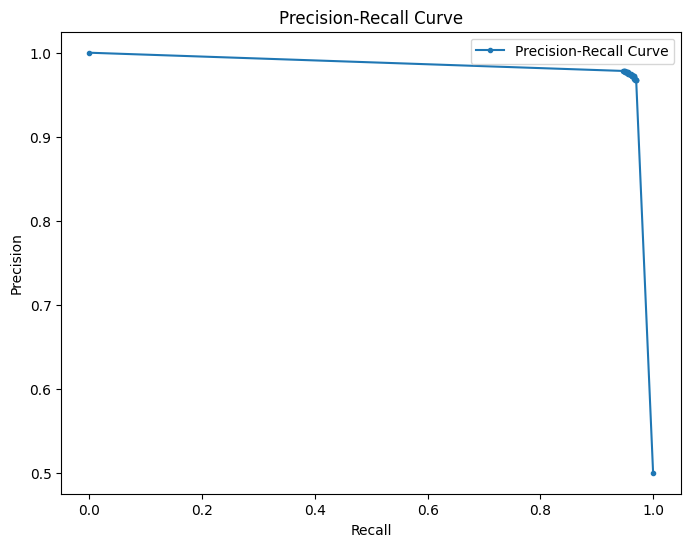

In [53]:
precision, recall, thresholds = precision_recall_curve(test_labels, predictions)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


#### **Exploring Incorrect Prediction**

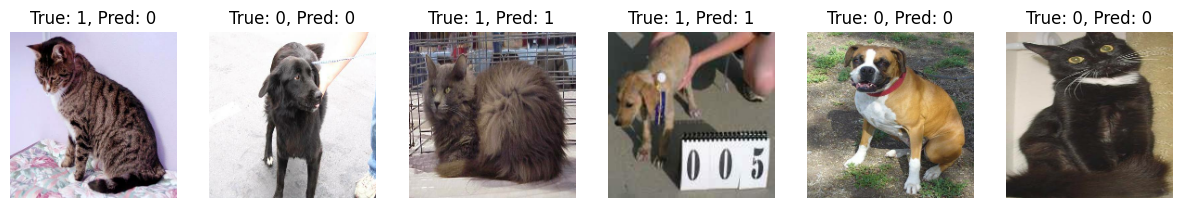

In [54]:
# Display a few misclassified examples
num_examples = 6 
plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    # Use the original images for visualization
    img = test_images[idx]  
    plt.imshow(img.astype("uint8"))  
    plt.title(f"True: {test_labels[idx]}, Pred: {predicted_classes[idx][0]}")
    plt.axis("off")
plt.show()


### **Fine-tuning a pretrained model**

In [55]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [57]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 180, 180,  │          0 │ input_layer_6[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Freezing all layers until the fourth from the last

In [58]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

#### Fine-tuning the model

In [59]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 653s 10s/step - accuracy: 0.7194 - loss: 5.0638 - val_accuracy: 0.9330 - val_loss: 0.6285
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 588s 9s/step - accuracy: 0.8872 - loss: 0.9489 - val_accuracy: 0.9560 - val_loss: 0.4095
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 571s 9s/step - accuracy: 0.9114 - loss: 0.7454 - val_accuracy: 0.9620 - val_loss: 0.2809
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 600s 10s/step - accuracy: 0.9377 - loss: 0.3708 - val_accuracy: 0.9650 - val_loss: 0.2611
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 563s 9s/step - accuracy: 0.9277 - loss: 0.3501 - val_accuracy: 0.9700 - val_loss: 0.2096
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 576s 9s/step - accuracy: 0.9491 - loss: 0.2128 - val_accuracy: 0.9720 - val_loss: 0.1949
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 579s 9s/step - accuracy: 0.9535 - loss: 0.1862 - val_accuracy: 0.9720 - val_loss: 0.1699
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 585s 9s/step - accuracy: 0.9555 - loss: 0.1985 - val_accuracy: 0.9730 -

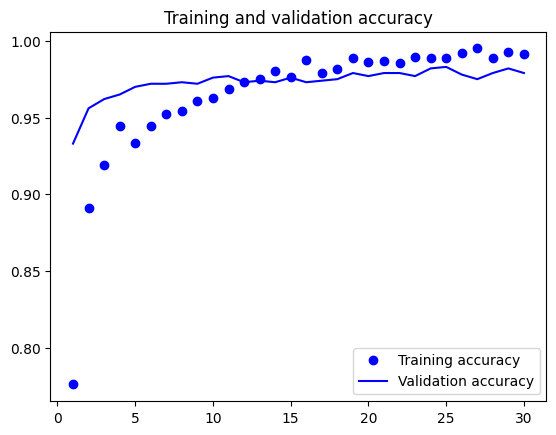

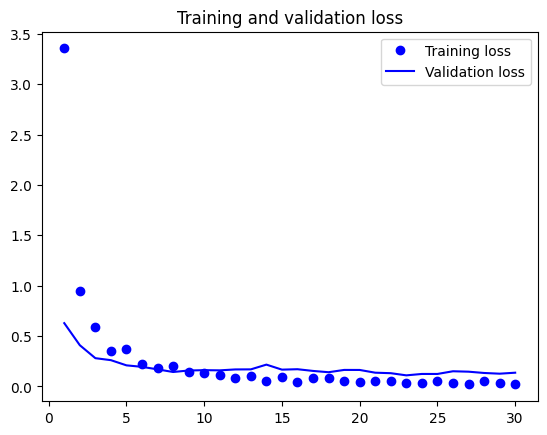

In [60]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 335s 5s/step - accuracy: 0.9711 - loss: 0.1979
Test accuracy: 0.973
63/63 ━━━━━━━━━━━━━━━━━━━━ 350s 6s/step


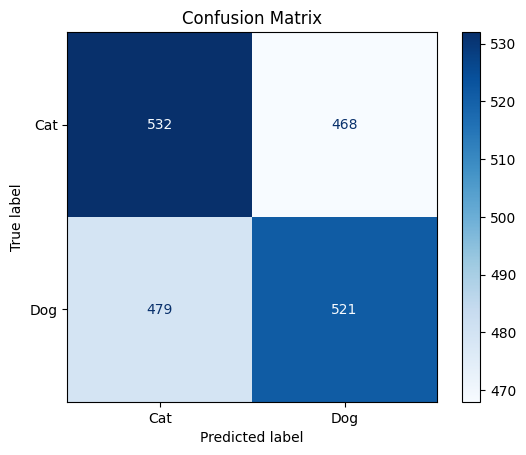

Precision: 0.527, Recall: 0.521, F1-Score: 0.524

Classification Report:
              precision    recall  f1-score   support

         Cat       0.53      0.53      0.53      1000
         Dog       0.53      0.52      0.52      1000

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000



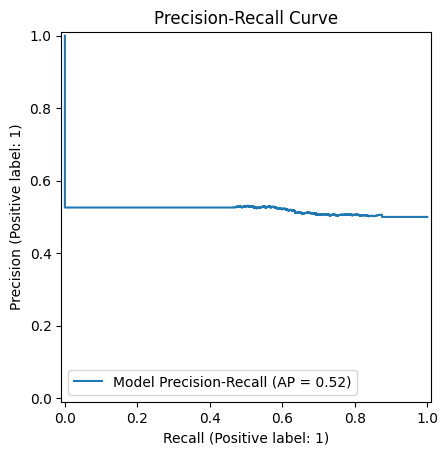

Number of misclassified examples: 947


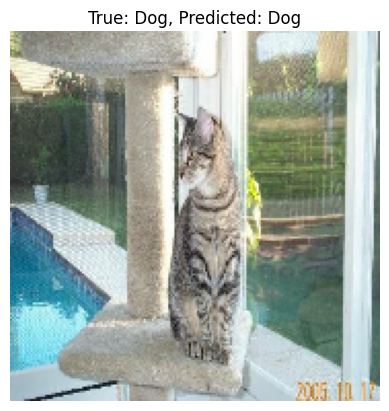

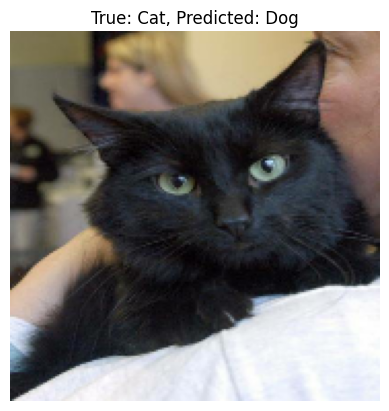

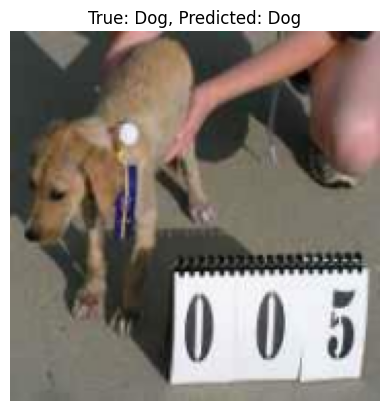

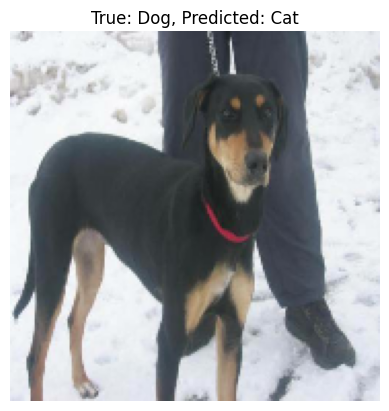

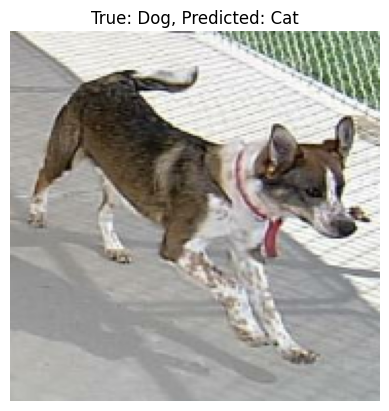

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np

# Load the model
model = keras.models.load_model("./models/fine_tuning.keras")

# Evaluate accuracy on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

# Get true labels and predicted probabilities
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
pred_probs = model.predict(test_dataset)
predictions = (pred_probs > 0.5).astype("int32")

# 1. Confusion Matrix
cm = confusion_matrix(y_true=true_labels, y_pred=predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 2. Precision, Recall, and F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="binary")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Cat", "Dog"]))

# 3. Precision-Recall Curve
disp = PrecisionRecallDisplay.from_predictions(true_labels, pred_probs, name="Model Precision-Recall")
plt.title("Precision-Recall Curve")
plt.show()

# 4. Misclassified Examples
misclassified_indices = np.where(true_labels != predictions.flatten())[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

# Explore specific misclassified examples
import matplotlib.pyplot as plt

for idx in misclassified_indices[:5]:  # Show first 5 misclassified examples
    image = test_images[idx]
    true_label = "Dog" if test_labels[idx] == 1 else "Cat"
    predicted_label = "Dog" if predictions[idx] == 1 else "Cat"

    plt.imshow(image.astype("uint8"))
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()



#### **Accuracy**

In [62]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 333s 5s/step - accuracy: 0.9703 - loss: 0.1887
Test accuracy: 0.973


#### **Confusion Matrix**

In [64]:
# Get true labels and predicted probabilities
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
pred_probs = model.predict(test_dataset)
predictions = (pred_probs > 0.5).astype("int32")

63/63 ━━━━━━━━━━━━━━━━━━━━ 361s 6s/step


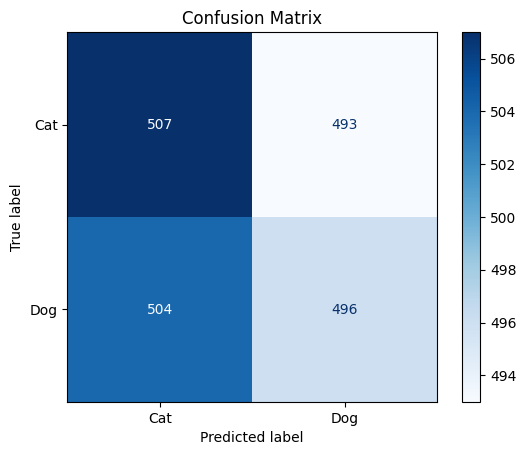

In [65]:
cm = confusion_matrix(y_true=true_labels, y_pred=predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### **Precision, Recall, and F1-Score**

In [66]:
# 2. Precision, Recall, and F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="binary")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")

Precision: 0.502, Recall: 0.496, F1-Score: 0.499


#### **Precision-Recall Curve**

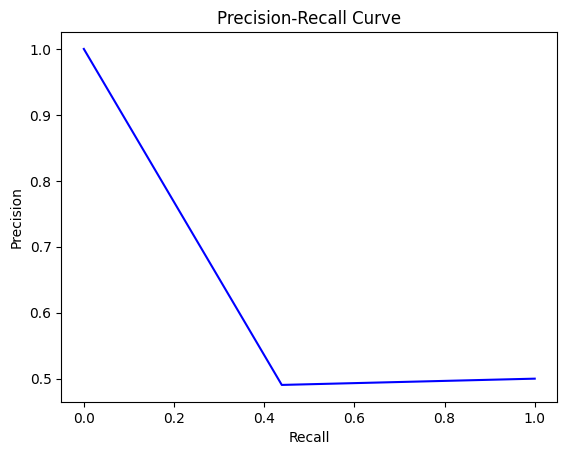

Area Under Precision-Recall Curve (PR AUC): 0.605


In [67]:
# 4. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred)
plt.plot(recall_vals, precision_vals, color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Area under the precision-recall curve
pr_auc = auc(recall_vals, precision_vals)
print(f"Area Under Precision-Recall Curve (PR AUC): {pr_auc:.3f}")

#### **Exploring Incorrect Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.8093324..253.46295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..246.92595].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.90005493..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [82.68366..255.0].


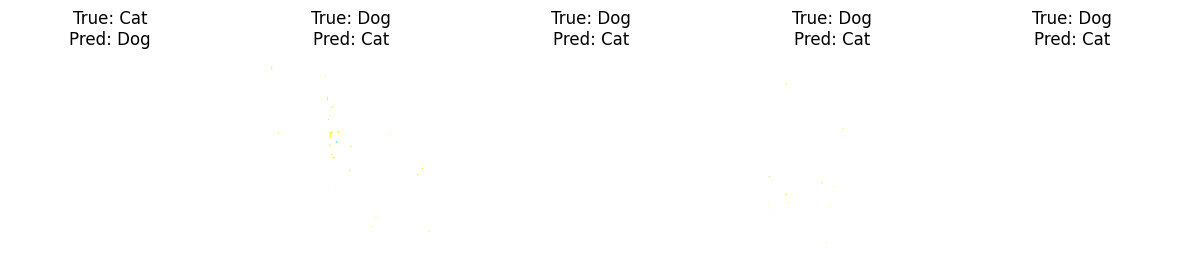

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# List to store misclassified examples
wrong_predictions = []

# Loop through the test dataset
for img_batch, label_batch in test_dataset:
    # Get model predictions for the batch
    preds = model.predict(img_batch)
    
    # Iterate over each image in the batch
    for i in range(len(preds)):
        # Convert predictions to binary (0 for Cat, 1 for Dog)
        pred_label = 1 if preds[i] > 0.5 else 0
        true_label = label_batch[i].numpy()  # True label
        
        # Check if prediction is incorrect
        if pred_label != true_label:
            # Append the misclassified image, its true label, and predicted label
            wrong_predictions.append((img_batch[i], true_label, pred_label))

# Displaying a few failed predictions
num_examples_to_show = 5
plt.figure(figsize=(15, 5))

# Loop through the misclassified examples
for i in range(min(num_examples_to_show, len(wrong_predictions))):
    img, true_label, pred_label = wrong_predictions[i]
    
    # Plot the image
    plt.subplot(1, num_examples_to_show, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {'Cat' if true_label == 0 else 'Dog'}\nPred: {'Cat' if pred_label == 0 else 'Dog'}")

plt.show()
